# Import Libaries

In [83]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SubsetRandomSampler, random_split

from pinn_loss import loss_fn_data, l1_regularization, pde_loss, boundary_loss, ic_loss, accuracy
from Input_vec_gen import input_gen, temp_data_gen, st_gen, meshgen, input_3gen
from Datagen import sim1d
from sampler import g_sampler, strat_sampler

# Generate Data

In [84]:
## Load Data 

In [85]:
L1 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=10.0,htc_r= 12.0, length =15.0e-3)
                
L2 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, \
            t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=12.0,htc_r= 12.0, length =15.0e-3)
L3 = sim1d(rho_l=2460.0, rho_s=2710.0, k_l=104.0, k_s= 96.2, cp_l=1245.3, cp_s=963.0, 
               t_surr=298.0, L_fusion=389000, temp_init=913.0, htc_l=15.0,htc_r= 12.0, length =15.0e-3)          



Stable
Stable
Stable


## Prepare the input and output vectors

In [86]:
length = 15.0e-3 # length of the rod
time_end =40 # end time of the simulation
htc_l_1,htc_l_2,htc_l_3 = 10.0,12.0,15.0 # htc values for the 3 simulations

# Extract the temperature, space and time vectors from the simulation data
T1,space_1,time_1 = L1[0],L1[1],L1[2] # 1st element is the temperature matrix, 2nd is the space vector, 3rd is the time vector
T2,space_2,time_2 = L2[0],L2[1],L2[2]
T3,space_3,time_3 = L3[0],L3[1],L3[2]

Temp_1,space_a1, time_a1 = np.array(T1),np.array(space_1),np.array(time_1)
Temp_2,space_a2, time_a2 = np.array(T2),np.array(space_2),np.array(time_2)
Temp_3,space_a3, time_a3 = np.array(T3),np.array(space_3),np.array(time_3)

# generate htc_l values





In [87]:
scaler = StandardScaler()

# Normalize the data

Temp_1n,Temp_2n, Temp_3n = scaler.fit_transform(Temp_1),scaler.fit_transform(Temp_2),scaler.fit_transform(Temp_3)
Space_1n,Space_2n, Space_3n = scaler.fit_transform(space_a1.reshape(-1,1)),scaler.fit_transform(space_a2.reshape(-1,1)),scaler.fit_transform(space_a3.reshape(-1,1))
Time_1n,Time_2n, Time_3n = scaler.fit_transform(time_a1.reshape(-1,1)),scaler.fit_transform(time_a2.reshape(-1,1)),scaler.fit_transform(time_a3.reshape(-1,1))

print(Temp_1n.shape,Space_1n.shape,Time_1n.shape)


(31470, 50) (50, 1) (31470, 1)


## standardize outputs

In [88]:
Temp_1_pde,Temp_1_ic,Temp_1_bc_l,Temp_1_bc_r = temp_data_gen(Temp_1n,Space_1n,Time_1n)
Temp_2_pde,Temp_2_ic,Temp_2_bc_l,Temp_2_bc_r = temp_data_gen(Temp_2n,Space_2n,Time_2n)
Temp_3_pde,Temp_3_ic,Temp_3_bc_l,Temp_3_bc_r = temp_data_gen(Temp_3n,Space_3n,Time_3n)



Temp_1n_tr,Temp_2n_tr,Temp_3n_tr = Temp_1n.flatten(),Temp_2n.flatten(),Temp_3n.flatten()
Temp_all = np.concatenate((Temp_1n_tr,Temp_2n_tr,Temp_3n_tr))
print(Temp_all.shape)
Temp_1pde_tr,Temp_2pde_tr,Temp_3pde_tr = Temp_1_pde.flatten(),Temp_2_pde.flatten(),Temp_3_pde.flatten()
Temp_pde_all = np.concatenate((Temp_1pde_tr,Temp_2pde_tr,Temp_3pde_tr))


Temp_1ic_tr,Temp_2ic_tr,Temp_3ic_tr = Temp_1_ic.flatten(),Temp_2_ic.flatten(),Temp_3_ic.flatten()
Temp_ic_all = np.concatenate((Temp_1ic_tr,Temp_2ic_tr,Temp_3ic_tr))


Temp_1bcl_tr,Temp_2bcl_tr,Temp_3bcl_tr = Temp_1_bc_l.flatten(),Temp_2_bc_l.flatten(),Temp_3_bc_l.flatten()
Temp_bcl_all = np.concatenate((Temp_1bcl_tr,Temp_2bcl_tr,Temp_3bcl_tr))


Temp_1bcr_tr,Temp_2bcr_tr,Temp_3bcr_tr = Temp_1_bc_r.flatten(),Temp_2_bc_r.flatten(),Temp_3_bc_r.flatten()
Temp_bcr_all = np.concatenate((Temp_1bcr_tr,Temp_2bcr_tr,Temp_3bcr_tr))




(4720500,)


Generate input vector

## Generate htc inputs

In [89]:
sp_pde_1,sp_ic_1,sp_bc_l_1,sp_bc_r_1 = st_gen(Space_1n,Time_1n)[0],st_gen(Space_1n,Time_1n)[1],\
                                        st_gen(Space_1n,Time_1n)[2],st_gen(Space_1n,Time_1n)[3]
t_pde_1,t_ic_1,t_bc_l_1,t_bc_r_1 = st_gen(Space_1n,Time_1n)[4],st_gen(Space_1n,Time_1n)[5],\
                                    st_gen(Space_1n,Time_1n)[6],st_gen(Space_1n,Time_1n)[7]

print(sp_pde_1.shape,sp_ic_1.shape,sp_bc_l_1.shape,sp_bc_r_1.shape)
print(t_pde_1.shape,t_ic_1.shape,t_bc_l_1.shape,t_bc_r_1.shape)

(31469, 48) (50,) (31470,) (31470,)
(31469, 48) (50,) (31470,) (31470,)


## Region 1

In [90]:
sp_pdtr_1 ,t_pdtr_1 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_1 = np.ones(sp_pdtr_1.shape)* htc_l_1
inp_pde_1 = input_3gen(sp_pdtr_1,t_pdtr_1,htc_lpde_1)

sp_ic_1,t_ic_1 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_1 = np.ones(sp_ic_1.shape)*htc_l_1
inp_ic_1 = input_3gen(sp_ic_1,t_ic_1,htc_ic_l_1)

sp_bc_l_1,t_bc_l_1 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_1 = np.ones(sp_bc_l_1.shape)*htc_l_1
inp_bc_l_1 = input_3gen(sp_bc_l_1,t_bc_l_1,htc_bc_l_1)

sp_bc_r_1,t_bc_r_1 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_1 = np.ones(sp_bc_r_1.shape)*htc_l_1
inp_bc_r_1 = input_3gen(sp_bc_r_1,t_bc_r_1,htc_bc_r_1) 

Space_1n_tr,Time_1n_tr = np.meshgrid(Space_1n,Time_1n)
Space_tr_1,Time_tr_1 = meshgen(Space_1n_tr,Time_1n_tr)
htc_tr_1 = np.ones(Space_tr_1.shape)*htc_l_1
inp_tr_1 = input_3gen(Space_tr_1,Time_tr_1,htc_tr_1)

## Region 2

In [91]:
sp_pdtr_2 ,t_pdtr_2 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_2 = np.ones(sp_pdtr_2.shape)* htc_l_2
inp_pde_2 = input_3gen(sp_pdtr_2,t_pdtr_2,htc_lpde_2)

sp_ic_2,t_ic_2 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_2 = np.ones(sp_ic_2.shape)*htc_l_2
inp_ic_2 = input_3gen(sp_ic_2,t_ic_2,htc_ic_l_2)

sp_bc_l_2,t_bc_l_2 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_2 = np.ones(sp_bc_l_2.shape)*htc_l_2
inp_bc_l_2 = input_3gen(sp_bc_l_2,t_bc_l_2,htc_bc_l_2)

sp_bc_r_2,t_bc_r_2 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_2 = np.ones(sp_bc_r_2.shape)*htc_l_2
inp_bc_r_2 = input_3gen(sp_bc_r_2,t_bc_r_2,htc_bc_r_2)

Space_2n_tr,Time_2n_tr = np.meshgrid(Space_2n,Time_2n)
Space_tr_2,Time_tr_2 = meshgen(Space_2n_tr,Time_2n_tr)
htc_tr_2 = np.ones(Space_tr_2.shape)*htc_l_2
inp_tr_2 = input_3gen(Space_tr_2,Time_tr_2,htc_tr_2)



## Region 3

In [92]:
sp_pdtr_3 ,t_pdtr_3 = meshgen(sp_pde_1,t_pde_1)
htc_lpde_3 = np.ones(sp_pdtr_3.shape)* htc_l_3
inp_pde_3 = input_3gen(sp_pdtr_3,t_pdtr_3,htc_lpde_3)

sp_ic_3,t_ic_3 = meshgen(sp_ic_1,t_ic_1)
htc_ic_l_3 = np.ones(sp_ic_3.shape)*htc_l_3
inp_ic_3 = input_3gen(sp_ic_3,t_ic_3,htc_ic_l_3)

sp_bc_l_3,t_bc_l_3 = meshgen(sp_bc_l_1,t_bc_l_1)
htc_bc_l_3 = np.ones(sp_bc_l_3.shape)*htc_l_3
inp_bc_l_3 = input_3gen(sp_bc_l_3,t_bc_l_3,htc_bc_l_3)

sp_bc_r_3,t_bc_r_3 = meshgen(sp_bc_r_1,t_bc_r_1)
htc_bc_r_3 = np.ones(sp_bc_r_3.shape)*htc_l_3
inp_bc_r_3 = input_3gen(sp_bc_r_3,t_bc_r_3,htc_bc_r_3)

Space_3n_tr,Time_3n_tr = np.meshgrid(Space_3n,Time_3n)
Space_tr_3,Time_tr_3 = meshgen(Space_3n_tr,Time_3n_tr)
htc_tr_3 = np.ones(Space_tr_3.shape)*htc_l_3
inp_tr_3 = input_3gen(Space_tr_3,Time_tr_3,htc_tr_3)

print(inp_pde_1.shape,inp_ic_1.shape,inp_bc_l_1.shape,inp_bc_r_1.shape,inp_tr_1.shape)

(1510512, 3) (50, 3) (31470, 3) (31470, 3) (1573500, 3)


## Combining all data

In [93]:
sp_pdtr_all = np.concatenate((sp_pdtr_1,sp_pdtr_2,sp_pdtr_3),axis=0)
t_pdtr_all = np.concatenate((t_pdtr_1,t_pdtr_2,t_pdtr_3),axis=0)
htc_lpde_all = np.concatenate((htc_lpde_1,htc_lpde_2,htc_lpde_3),axis=0)
inp_pde_all = np.concatenate((inp_pde_1,inp_pde_2,inp_pde_3),axis=0)
print(inp_pde_all.shape)
sp_ic_all = np.concatenate((sp_ic_1,sp_ic_2,sp_ic_3),axis=0)
t_ic_all = np.concatenate((t_ic_1,t_ic_2,t_ic_3),axis=0)
htc_ic_l_all = np.concatenate((htc_ic_l_1,htc_ic_l_2,htc_ic_l_3),axis=0)
inp_ic_all = np.concatenate((inp_ic_1,inp_ic_2,inp_ic_3),axis=0)

print(inp_ic_all.shape)
sp_bc_l_all = np.concatenate((sp_bc_l_1,sp_bc_l_2,sp_bc_l_3),axis=0)
t_bc_l_all = np.concatenate((t_bc_l_1,t_bc_l_2,t_bc_l_3),axis=0)
htc_bc_l_all = np.concatenate((htc_bc_l_1,htc_bc_l_2,htc_bc_l_3),axis=0)
inp_bc_l_all = np.concatenate((inp_bc_l_1,inp_bc_l_2,inp_bc_l_3),axis=0)
print(inp_bc_l_all.shape)
sp_bc_r_all = np.concatenate((sp_bc_r_1,sp_bc_r_2,sp_bc_r_3),axis=0)
t_bc_r_all = np.concatenate((t_bc_r_1,t_bc_r_2,t_bc_r_3),axis=0)
htc_bc_r_all = np.concatenate((htc_bc_r_1,htc_bc_r_2,htc_bc_r_3),axis=0)
inp_bc_r_all = np.concatenate((inp_bc_r_1,inp_bc_r_2,inp_bc_r_3),axis=0)
print(inp_bc_r_all.shape)
Space_all_tr = np.concatenate((Space_tr_1,Space_tr_2,Space_tr_3),axis=0)
Time_all_tr = np.concatenate((Time_tr_1,Time_tr_2,Time_tr_3),axis=0)
htc_tr_all = np.concatenate((htc_tr_1,htc_tr_2,htc_tr_3),axis=0)
inp_tr_all = np.concatenate((inp_tr_1,inp_tr_2,inp_tr_3),axis=0)
print(inp_tr_all.shape)


(4531536, 3)
(150, 3)
(94410, 3)
(94410, 3)
(4720500, 3)


# Plot the Analytical Data

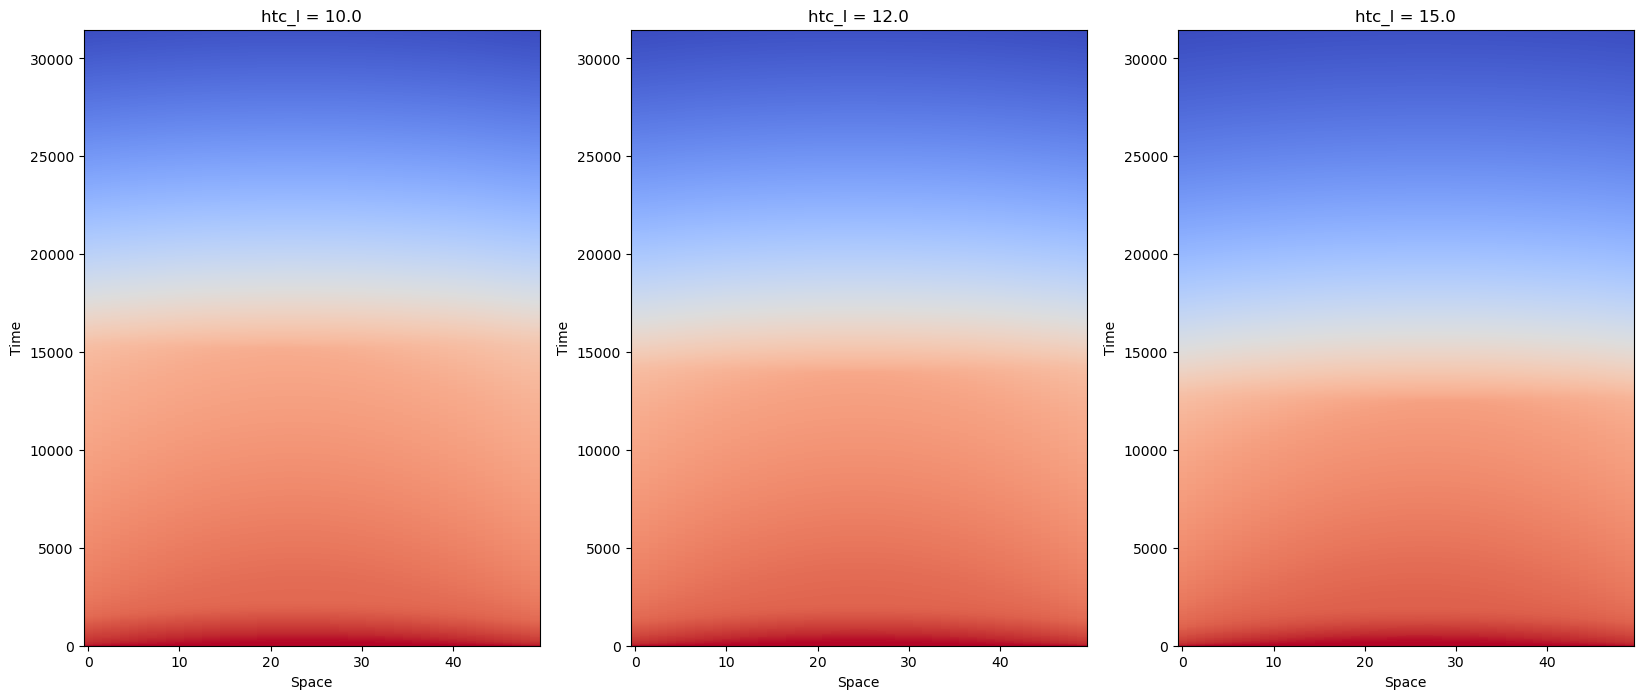

In [94]:
# plt a subplot of the three plots
space_cord, time_cord = np.meshgrid(np.arange(T1.shape[1]), np.arange(T1.shape[0]))
fig, axs = plt.subplots(1, 3, figsize=(20, 8))
axs[0].pcolormesh(space_cord, time_cord, T1, cmap='coolwarm', shading='auto')
axs[0].set_title('htc_l = 10.0')
axs[0].set_xlabel('Space')
axs[0].set_ylabel('Time')
axs[1].pcolormesh(space_cord, time_cord, T2, cmap='coolwarm', shading='auto')
axs[1].set_title('htc_l = 12.0')
axs[1].set_xlabel('Space')
axs[1].set_ylabel('Time')
axs[2].pcolormesh(space_cord, time_cord, T3, cmap='coolwarm', shading='auto')
axs[2].set_title('htc_l = 15.0')
axs[2].set_xlabel('Space')
axs[2].set_ylabel('Time')
plt.show()


In [95]:
# check for gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device2 = torch.device('cpu')
print('Using device:', device)

Using device: cuda


# Data Preparation

## Sampler Preparation



In [97]:
t_surr = 298.0 # Surrounding temperature
t_init = 913.0 # Initial temperature
inputs_sam, T_sam = strat_sampler(inp_tr_all,Temp_all,0.01) # Sample the input and output data
inputs_pde_sam, T_pde_sam = strat_sampler(inp_pde_all,Temp_pde_all,0.01) # Sample the input and output data for pde 
inputs_i_sam,T_ic_sam = strat_sampler(inp_ic_all,Temp_ic_all,1) # Sample the input and output data for initial condition
inputs_b_l_sam,T_bcl_sam = strat_sampler(inp_bc_l_all,Temp_bcl_all,0.2) # Sample the input and output data for boundary condition left
inputs_b_r_sam, T_bcr_sam = strat_sampler(inp_bc_r_all, Temp_bcr_all, 0.2) # Sample the input and output data for boundary condition right

print(inputs_sam.shape,T_sam.shape)
print(inputs_pde_sam.shape,T_pde_sam.shape)
print(inputs_i_sam.shape,T_ic_sam.shape)
print(inputs_b_l_sam.shape,T_bcl_sam.shape)
print(inputs_b_r_sam.shape,T_bcr_sam.shape)


(47205, 3) (47205,)
(45315, 3) (45315,)
(150, 3) (150,)
(18882, 3) (18882,)
(18882, 3) (18882,)


## Tensor the Sample Dataset

In [98]:
inp_sam, T_sam = torch.tensor(inputs_sam).float(), torch.tensor(T_sam).float()
inp_pde_sam, T_pde_sam = torch.tensor(inputs_pde_sam).float(), torch.tensor(T_pde_sam).float()
inp_i_sam, T_ic_sam = torch.tensor(inputs_i_sam).float(), torch.tensor(T_ic_sam).float()
inp_b_l_sam, T_bcl_sam = torch.tensor(inputs_b_l_sam).float(), torch.tensor(T_bcl_sam).float()
inp_b_r_sam, T_bcr_sam = torch.tensor(inputs_b_r_sam).float(), torch.tensor(T_bcr_sam).float()


## Data splitting

In [99]:
train_inp_sam,test_inp_sam,train_T_sam,test_T_sam = train_test_split(inp_sam,T_sam,\
                                                                     test_size=0.2,random_state=42)
train_inp_pde_sam,test_inp_pde_sam,train_T_pde_sam,test_T_pde_sam = train_test_split(inp_pde_sam,T_pde_sam,\
                                                                                     test_size=0.2,random_state=42)
train_inp_i_sam,test_inp_i_sam,train_T_i_sam,test_T_i_sam = train_test_split(inp_i_sam,T_ic_sam,\
                                                                             test_size=0.2,random_state=42)
train_inp_b_l_sam,test_inp_b_l_sam,train_T_b_l_sam,test_T_b_l_sam = train_test_split(inp_b_l_sam,T_bcl_sam, \
                                                                                     test_size=0.2,random_state=42)
train_inp_b_r_sam,test_inp_b_r_sam,train_T_b_r_sam,test_T_b_r_sam = train_test_split(inp_b_r_sam,T_bcr_sam,\
                                                                                     test_size=0.2,random_state=42)


## Dataloader

In [100]:
class PinnDataset(torch.utils.data.Dataset):
    def __init__(self, inputs, targets):
        self.inputs = inputs
        self.targets = targets

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

## Dataset Prep

In [101]:
train_dataset = PinnDataset(train_inp_sam, train_T_sam)
test_dataset = PinnDataset(test_inp_sam, test_T_sam)

train_pde_dataset = PinnDataset(train_inp_pde_sam, train_T_pde_sam)
test_pde_dataset = PinnDataset(test_inp_pde_sam, test_T_pde_sam)

train_ic_dataset = PinnDataset(train_inp_i_sam, train_T_i_sam)
test_ic_dataset = PinnDataset(test_inp_i_sam, test_T_i_sam)

train_b_l_dataset = PinnDataset(train_inp_b_l_sam, train_T_b_l_sam)
test_b_l_dataset = PinnDataset(test_inp_b_l_sam, test_T_b_l_sam)

train_b_r_dataset = PinnDataset(train_inp_b_r_sam, train_T_b_r_sam)
test_b_r_dataset = PinnDataset(test_inp_b_r_sam, test_T_b_r_sam)


In [ ]:
#try random sampler if it doesnt work

In [102]:

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

train_pde_loader = DataLoader(train_pde_dataset, batch_size=64, shuffle=True)
test_pde_loader = DataLoader(test_pde_dataset, batch_size=64, shuffle=True)

train_ic_loader = DataLoader(train_ic_dataset, batch_size=64, shuffle=True)
test_ic_loader = DataLoader(test_ic_dataset, batch_size=64, shuffle=True)

train_b_l_loader = DataLoader(train_b_l_dataset, batch_size=64, shuffle=True)
test_b_l_loader = DataLoader(test_b_l_dataset, batch_size=64, shuffle=True)

train_b_r_loader = DataLoader(train_b_r_dataset, batch_size=64, shuffle=True)
test_b_r_loader = DataLoader(test_b_r_dataset, batch_size=64, shuffle=True)


# Model Development

In [103]:
# prepare data into interior , boundary and initial condition
class Pinn_Var(nn.Module):
    def __init__(self, input_size, hidden_size, output_size): # This is the constructor
        super(Pinn_Var, self).__init__()
        self.base = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, hidden_size),
            # nn.BatchNorm1d(hidden_size),
            nn.Sigmoid(),
            nn.Linear(hidden_size, output_size)
        )
        
    def forward(self, x, t, h):                               # This is the forward pass
        input_features = torch.cat([x, t, h], dim=1)          # Concatenate the input features
        m = self.base(input_features)                                 # Pass through the third layer
        return m                    # Return the output of the network



In [104]:
# Hyperparameters
hidden_size = 20
learning_rate = 0.003
epochs = 30000
# alpha = 0.01  # Adjust this value based on your problem
# boundary_value = 313.0
# initial_value = init_temp
# Initialize the model
model = Pinn_Var(input_size=3, hidden_size=hidden_size,output_size=1).to(device)
lambd = 0.1

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Training & Testing Loop 

In [105]:
train_losses = []
val_losses = []
test_losses = []

In [107]:
def training_loop(epochs, model, loss_fn_data, optimizer, train_loader,test_dataloader,\
                  train_pde_loader,train_loader_init,\
                    train_loader_bc_l,train_loader_bc_r):
    train_losses = []  # Initialize the list to store the training losses
    # val_losses = []    # Initialize the list to store the validation losses
    test_losses = []   # Initialize the list to store the test losses
    data_losses = []   # Initialize the list to store the data losses
    pde_losses = []   # Initialize the list to store the PDE losses
    ic_losses = []   # Initialize the list to store the initial condition losses
    bc_losses = []   # Initialize the list to store the boundary condition losses

    for epoch in range(epochs):
        model.train()                                                                           # Set the model to training mode
        train_loss = 0                                                                              # Initialize the training loss
        train_accuracy = 0
        for (batch,batch_pde,batch_init,batch_left,batch_right) in \
             zip (train_loader,train_pde_loader,train_loader_init,train_loader_bc_l,train_loader_bc_r):                                                          # Loop through the training dataloader
            
            train_inputs_sample, train_temp_inp_sample= batch                                                             # Get the inputs and the true values
            
            train_pde_sample, train_temp_inp_pde_sample= batch_pde                                                             # Get the inputs and the true values
            
            train_inputs_i_sample, train_temp_inp_i_sample= batch_init                                                             # Get the inputs and the true values 
            
            train_inputs_bc_l_sample, train_temp_inp_bc_l_sample= batch_left                                                             # Get the inputs and the true values
            train_inputs_bc_r_sample, train_temp_inp_bc_r_sample= batch_right                                                             # Get the inputs and the true values

            train_inputs_sample, train_temp_inp_sample= train_inputs_sample.to(device), train_temp_inp_sample.to(device)                                                             # Get the inputs and the true values
            
            train_pde_sample, train_temp_inp_pde_sample= train_pde_sample.to(device), train_temp_inp_pde_sample.to(device)                                                             # Get the inputs and the true values
            
            train_inputs_i_sample, train_temp_inp_i_sample= train_inputs_i_sample.to(device), train_temp_inp_i_sample.to(device)                                                            # Get the inputs and the true values 
            
            train_inputs_bc_l_sample, train_temp_inp_bc_l_sample=  train_inputs_bc_l_sample.to(device), train_temp_inp_bc_l_sample.to(device)                                                            # Get the inputs and the true values
            train_inputs_bc_r_sample, train_temp_inp_bc_r_sample= train_inputs_bc_r_sample.to(device), train_temp_inp_bc_r_sample.to(device)
            
            
            # print(inputs.shape)
            # print(inputs_init.shape)
            # print(inputs_left.shape)
            # print(inputs_right.shape)

            optimizer.zero_grad()                                                                    # Zero the gradients
            
            # Forward pass
            u_pred = model(train_inputs_sample[:,0].unsqueeze(1), train_inputs_sample[:,1].unsqueeze(1),\
                           train_inputs_sample[:,2].unsqueeze(1))                       # Get the predictions
            u_initl = model(train_inputs_i_sample[:,0].unsqueeze(1), train_inputs_i_sample[:,1].unsqueeze(1),\
                            train_inputs_i_sample[:,2].unsqueeze(1))                       # Get the predictions
            u_left = model(train_inputs_bc_l_sample[:,0].unsqueeze(1), train_inputs_bc_l_sample[:,1].unsqueeze(1),\
                           train_inputs_bc_l_sample[:,2].unsqueeze(1))               # Left boundary of the temperature
            u_right = model(train_inputs_bc_r_sample[:,0].unsqueeze(1), train_inputs_bc_r_sample[:,1].unsqueeze(1),\
                            train_inputs_bc_r_sample[:,2].unsqueeze(1))             # Right boundary of the temperature

            # Loss calculation
            data_loss = loss_fn_data(u_pred, train_temp_inp_sample)                                              # Calculate the data loss
            
            pd_loss = pde_loss(model,train_pde_sample[:,0].unsqueeze(1),train_pde_sample[:,1].unsqueeze(1),\
                               train_pde_sample[:,2].unsqueeze(1))             # Calculate the PDE loss
            # pd_loss = 0
            
            initc_loss = ic_loss(u_initl) 
            # initc_loss =0                                                      # Calculate initial condition loss
            
            bc_loss_left = boundary_loss(model,train_inputs_bc_l_sample[:,0].unsqueeze(1),\
                                         train_inputs_bc_l_sample[:,1].unsqueeze(1),\
                                            train_inputs_bc_l_sample[:,2].unsqueeze(1),\
                                            t_surr) # Calculate the left boundary condition loss
            bc_loss_right = boundary_loss(model,train_inputs_bc_r_sample[:,0].unsqueeze(1),
                                          train_inputs_bc_r_sample[:,1].unsqueeze(1),\
                                            train_inputs_bc_r_sample[:,2].unsqueeze(1),\
                                            t_surr) # Calculate the right boundary condition loss
            bc_loss = bc_loss_left + bc_loss_right
            # l1_regularization_loss = l1_regularization(model, lambda_l1)                      # Calculate the L1 regularization loss
            # loss = data_loss  + pd_loss + initc_loss + bc_loss                                              # Calculate the total loss
            w1 = 1
            w2 = 1e4
            w3 = 1e2
            loss = data_loss + w1* pd_loss + w2 *initc_loss + w3* bc_loss
            train_accuracy += accuracy(u_pred, train_temp_inp_sample)                                                              # Calculate the total loss
            # Backpropagation
            loss.backward(retain_graph=True)                                                        # Backpropagate the gradients
            
            optimizer.step()                                                                           # Update the weights
            
            train_loss += loss.item()                                                           # Add the loss to the training set loss  
            data_loss += data_loss.item()
            pd_loss += pd_loss.item()
            initc_loss += initc_loss.item()
            bc_loss += bc_loss.item()
        
        train_losses.append(train_loss)
        data_losses.append(data_loss)
        pde_losses.append(pd_loss)
        ic_losses.append(initc_loss)
        bc_losses.append(bc_loss)


        model.eval()
        test_loss = 0
        test_accuracy = 0
        # with torch.no_grad(): 
        for batch in test_dataloader:
            test_inputs_sample, test_temp_inp_sample= batch
            test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
            u_pred = model(test_inputs_sample[:,0].unsqueeze(1), test_inputs_sample[:,1].unsqueeze(1),\
                           test_inputs_sample[:,2].unsqueeze(1))
            data_loss_t = loss_fn_data(u_pred, test_temp_inp_sample)
            # l1_regularization_loss = l1_regularization(model, lambd)
            # loss = data_loss  + l1_regularization_loss
            
            loss = data_loss_t
            test_accuracy = accuracy(u_pred, test_temp_inp_sample)
            test_loss += loss.item()
        test_losses.append(test_loss)

                                                           # Append the training loss to the list of training losses
        
        


        if epoch % 10 == 0:
            print(f"Epoch {epoch},| Training-Loss {train_loss:.4e},| Data-loss {data_loss:.4e},"
                f"pde-loss {pd_loss:.4e}, initc-loss {initc_loss:.4e}|,"
                f"|bc_loss {bc_loss:.4e}, test-loss {test_loss:.4e}") 

    return train_losses, test_losses , pde_losses , bc_losses , ic_losses, data_losses                                                      # Return the training and validation losses


In [108]:
def test_loop(epochs, model, loss_fn_data, optimizer, train_dataloader, test_dataloader):
    for epoch in range(epochs):
        model.eval()
        test_loss = 0
        test_accuracy = 0
        with torch.no_grad():   
            for batch in test_dataloader:
                test_inputs_sample, test_temp_inp_sample= batch
                test_inputs_sample, test_temp_inp_sample= test_inputs_sample.to(device), test_temp_inp_sample.to(device)
                u_pred = model(test_inputs_sample[:,0].unsqueeze(1), test_inputs_sample[:,1].unsqueeze(1))
                data_loss = loss_fn_data(u_pred, test_temp_inp_sample)
                # l1_regularization_loss = l1_regularization(model, lambd)
                # loss = data_loss  + l1_regularization_loss
                
                loss = data_loss
                test_accuracy = accuracy(u_pred, test_temp_inp_sample)
                test_loss += loss.item()
        test_losses.append(test_loss)
        if epochs % 10 == 0:
            print(f"Epoch {epoch}, Test-Loss {test_loss:.4e}, Test-Accuracy {test_accuracy:.4e}")      
    return test_losses

# Model Run

In [109]:

train_losses, test_losses, pde_losses, bc_losses,ic_losses, data_losses = training_loop(epochs, model, \
                                        loss_fn_data, optimizer,train_loader,test_loader,\
                                            train_pde_loader, train_ic_loader,\
                                            train_b_l_loader,train_b_r_loader )  # Train the model
 
# test_losses = test_loop(epochs, model, loss_fn_data, optimizer, train_loader, test_loader)  # Test the model


   


    
    

/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/student.unimelb.edu.au/rrammohan/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([33])) that is different to the input size (torch.Size([33, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0,| Training-Loss 2.0468e+10,| Data-loss 2.2796e+00,pde-loss 2.6986e-06, initc-loss 1.6905e+06|,|bc_loss 3.5611e+07, test-loss 1.6479e+02
Epoch 10,| Training-Loss 2.0410e+10,| Data-loss 2.7108e+00,pde-loss 6.6294e-07, initc-loss 1.6870e+06|,|bc_loss 3.5383e+07, test-loss 2.0867e+02
Epoch 20,| Training-Loss 2.0353e+10,| Data-loss 6.2816e+00,pde-loss 8.6484e-07, initc-loss 1.6836e+06|,|bc_loss 3.5162e+07, test-loss 5.1263e+02
Epoch 30,| Training-Loss 2.0287e+10,| Data-loss 1.6892e+01,pde-loss 9.8355e-08, initc-loss 1.6795e+06|,|bc_loss 3.4899e+07, test-loss 1.2202e+03
Epoch 40,| Training-Loss 2.0211e+10,| Data-loss 3.7817e+01,pde-loss 4.3286e-07, initc-loss 1.6749e+06|,|bc_loss 3.4602e+07, test-loss 2.4564e+03
Epoch 50,| Training-Loss 2.0135e+10,| Data-loss 5.4409e+01,pde-loss 4.7770e-07, initc-loss 1.6703e+06|,|bc_loss 3.4307e+07, test-loss 4.1611e+03
Epoch 60,| Training-Loss 2.0055e+10,| Data-loss 8.6005e+01,pde-loss 4.8867e-07, initc-loss 1.6654e+06|,|bc_loss 3.3994e+07, test-lo

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.00 MiB. GPU 

# Plots

In [ ]:
inputs = torch.tensor(inp_tr_1).float().to(device) # Convert the inputs to a tensor
temp_nn = model(inputs[:,0].unsqueeze(1), inputs[:,1].unsqueeze(1),inputs[:,2].unsqueeze(1)).cpu().detach().numpy() # Get the predictions from the model
num_points = space_a1.shape[0] # Number of points in the space vector
print(temp_nn.shape)
temp_nn = temp_nn.reshape(time_a1.shape, space_a1.shape) # Reshape the predictions to a 2D array
print(temp_nn.shape)
time_ss= np.linspace(0, time_end, time_a1.shape)
plt.figure
plt.plot(time_ss, temp_nn[:, num_points//2], label='Predicted Temperature')
plt.plot(time_ss, T1[:,num_points//2], label='Actual Temperature')
plt.xlabel('Time(s)')
plt.ylabel('Temperature (K)')
plt.title('Predicted vs Actual Temperature at x = 7.5mm')
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='test Loss')
# plt.xticks(np.arange(0, epochs, 10000))
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
pde_losses_n = [tensor.cpu().detach().numpy() for tensor in pde_losses]
data_losses_n = [tensor.cpu().detach().numpy() for tensor in data_losses]
ic_losses_n = [tensor.cpu().detach().numpy() for tensor in ic_losses]
bc_losses_n = [tensor.cpu().detach().numpy() for tensor in bc_losses]

plt.figure(figsize=(10, 6))
plt.plot(data_losses_n, label='Data Loss')
plt.plot(pde_losses_n, label='Pde Loss')
plt.plot(ic_losses_n, label='IC Loss')
plt.plot(bc_losses_n, label='BC Loss')
plt.yscale('log')
# plt.axhline(y=1e-6, color='red', linestyle='--', label='Near-Zero Line')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [ ]:
space_coord, time_coord = np.meshgrid(np.arange(T1.shape[1]), np.arange(T1.shape[0]))

# time_coord = time_coord * dt 
# Create a figure with two subplots
print(space_coord.shape,time_coord.shape,T1.shape,temp_nn.shape)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))


# Plot the temperature history on the left subplot
im1 = ax1.pcolormesh(space_coord, time_coord, T1, cmap='viridis', shading='auto')
ax1.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax1.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax1.set_title('Temperature Variation Over Time(Analytical Model)',fontname='Times New Roman', fontsize=20)
ax1.contour(space_coord, time_coord, T1, colors='red', linewidths=1.0, alpha=0.9)

ax1.grid(True)
cbar = fig.colorbar(im1, ax=ax1)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)

im2 = ax2.pcolormesh(space_coord, time_coord, temp_nn, cmap='viridis', shading='auto')
ax2.set_xlabel('Space Coordinate', fontname='Times New Roman', fontsize=16)
ax2.set_ylabel('Time',fontname='Times New Roman', fontsize=16)
ax2.set_title('Temperature Variation Over Time(PINN Approach)',fontname='Times New Roman', fontsize=20)
ax2.contour(space_coord, time_coord, temp_nn, colors='red', linewidths=1.0, alpha=0.9)

ax2.grid(True)
cbar = fig.colorbar(im2, ax=ax2)
cbar.ax.invert_yaxis()
cbar.set_label('Temperature (K)', rotation=270, labelpad=20, fontname='Times New Roman', fontsize=16)


plt.tight_layout()
plt.show()
